## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import requests
import xml.etree.ElementTree as ET
from tensorflow import keras
from tensorflow.keras import layers

# Dataset

## Read Dataset

In [17]:
def get_data(url):
    '''Convert data fetched from API into pandas dataframe'''
    
    #API requests
    r = requests.get(url)
    #Parsing XML
    root = ET.fromstring(r.content)
    
    file_name = []
    for child in root:
        for item in child:
            if 'earthquake-damage-dataset' in item.text:
                file_name.append(item.text)
                
    testing_data = pd.read_csv(url+'/'+file_name[0])
    training_labels = pd.read_csv(url+'/'+file_name[1])
    training_data = pd.read_csv(url+'/'+file_name[2])
    
    return training_data, training_labels, testing_data

url = 'http://storage.googleapis.com/b21-cap0155-capstone-project-bucket-1'

train, labels, test = get_data(url)

# adding labels to train dataset
# train["damage_grade"]=labels["damage_grade"]
print("shape of the train dataset is : ", train.shape)
print("shape of the test dataset is  : ", test.shape)

change_value = {1: 0, 2: 1, 3: 2}
labels["damage_grade"] = labels["damage_grade"].map(change_value)

train = train.drop(["building_id"],axis=1)
labels = labels.drop(["building_id"],axis=1)
test = test.drop(["building_id"],axis=1)

train.head(5)

shape of the train dataset is :  (260601, 39)
shape of the test dataset is  :  (86868, 39)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


## Check Data

In [27]:
# checking the types of varibles in the dataset(int,float,object)
dtypes=pd.DataFrame(train.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=train.nunique()
dtypes["Null Values"]=train.isnull().sum()
dtypes["% null Values"]=train.isnull().sum()/len(train)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
geo_level_1_id,int64,31,0,0.000000
geo_level_2_id,int64,1414,0,0.000000
geo_level_3_id,int64,11595,0,0.000000
count_floors_pre_eq,int64,9,0,0.000000
age,int64,42,0,0.000000
area_percentage,int64,84,0,0.000000
height_percentage,int64,27,0,0.000000
has_superstructure_adobe_mud,int64,2,0,0.000000
has_superstructure_mud_mortar_stone,int64,2,0,0.000000
has_superstructure_stone_flag,int64,2,0,0.000000


## Graph data for Damage Grade

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


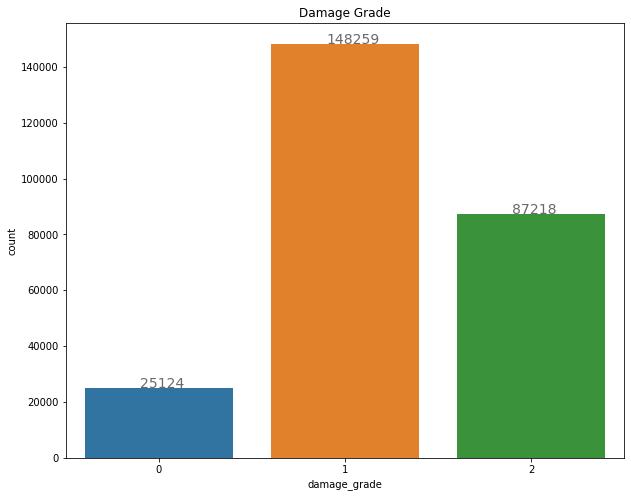

In [29]:
# checking the dependent variable --> `damage_grade`
plt.figure(figsize=(10,8))
ax=sns.countplot("damage_grade",data=labels)
for i in ax.patches:
    # for the number text
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.3, i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey')
plt.title("Damage Grade")
plt.show()  

## One Hot Labeling

In [30]:
# One hot labeling for categorical data
categorical_feature=['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status']

for column in list(train.columns):
    if column in categorical_feature:
        # Get one hot encoding of columns B
        one_hot = pd.get_dummies(train[column], prefix=column)
        # Drop column B as it is now encoded
        train = train.drop(column, axis = 1)
        # Join the encoded df
        train = train.join(one_hot)

# Model

In [31]:
# function dense layer with drop out
def dense_block(units, dropout_rate):
    block = keras.Sequential([
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate)
    ])
    return block

input_shape = len(feature_columns)
NUM_CLASSES = 3

# Model
model = keras.Sequential([
  layers.Dense(256, input_shape=[input_shape]),
  dense_block(128, 0.7),
  dense_block(64, 0.5),

  layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               17664     
_________________________________________________________________
sequential_9 (Sequential)    (None, 128)               33408     
_________________________________________________________________
sequential_10 (Sequential)   (None, 64)                8512      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 195       
Total params: 59,779
Trainable params: 59,395
Non-trainable params: 384
_________________________________________________________________


# K-Fold

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp_lr = lr0 * 0.1 ** (epoch / s)
        return exp_lr
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

EPOCHS = 10
kf = KFold(n_splits=5)
i = 1

scores = []
for train_index, test_index in kf.split(train):
    X_train, X_test = train.loc[train_index], train.loc[test_index]
    y_train, y_test = labels.loc[train_index], labels.loc[test_index]
    
    print('Model k-fold : ' + str(i))

    model.fit(
        X_train,
        y_train,
        callbacks=[lr_scheduler],
        epochs=EPOCHS
    )

    preds_classes = np.argmax(model.predict(X_test), axis=-1)
    scores.append(accuracy_score(y_test, preds_classes))
    print('Accuracy : ', accuracy_score(y_test, preds_classes))

    # Save Model
    model.save('kfold_model_' + str(i) + '.h5')
    i += 1
    
max_value = max(scores)
max_index = scores.index(max_value) + 1
print('Best model k-fold : ' + str(max_index))
print('With accuracy : ' + str(max_value))

Model k-fold : 1
Epoch 1/10
6515/6515 [==============================] - 22s 3ms/step - loss: 0.9400 - accuracy: 0.5584
Epoch 2/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.9135 - accuracy: 0.5693
Epoch 3/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.8881 - accuracy: 0.5669
Epoch 4/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.9144 - accuracy: 0.5668
Epoch 5/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.9071 - accuracy: 0.5678
Epoch 6/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.8639 - accuracy: 0.5679
Epoch 7/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.8502 - accuracy: 0.5649
Epoch 8/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.8367 - accuracy: 0.5677
Epoch 9/10
6515/6515 [==============================] - 21s 3ms/step - loss: 0.8323 - accuracy: 0.5671
Epoch 10/10
6515/6515 [==============================] -